# Task for Cuetessa, Inc. – Predicting Valence of Pop Songs - Tensorflow Keras | Convolutional Neural Network 
 
## Overview
The aim of this task is to develop a Python-based module to predict the valence of newly released pop songs.  Two approaches are to use as input 
1. the audio data (e.g., .wav files) of songs  
2. the lyrics of songs.  Publicly available datasets can be used for training and testing. 


### Data Description 

DEAM dataset (DEAM dataset - The MediaEval Database for Emotional Analysis of Music) consists of 1802 excerpts and full songs annotated with valence and arousal values both continuously (per-second) and over the whole song. The metadata describing the audio excerpts (their duration, genre, folksonomy tags).

- Annotations Data: The annotated dataset comes from Soleymani et al. (2013) (http://cvml.unige.ch/databases/emoMusic/). It consists of 45-s clips of 744 songs from the Free Music Archive (https://freemusicarchive.org/) that span a variety of popular genres
    - Annotations are made available in csv format. There are six csv files in this database, four containing
average and standard deviation of arousal and valence continuous annotation for each song.
- Metadata: 
    - including, song title, genre and artist is also provided.
    
    
### Feature Extraction

- [x] Mel Spectrogram

A Mel Spectrogram makes two important changes relative to a regular Spectrogram that plots Frequency vs Time.

    - It uses the Mel Scale instead of Frequency on the y-axis.
    - It uses the Decibel Scale instead of Amplitude to indicate colors.


In [1]:
# Initialization 

import pandas as pd
import numpy as np

# statistical visualization
import matplotlib.pyplot as plt
import seaborn as sns

import librosa as librosa
import librosa.display
import IPython.display as ipd

from scipy import stats as st

import os
import re
from tqdm import tqdm


# import module for splitting and cross-validation using gridsearch
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, get_scorer_names 
from sklearn.preprocessing import StandardScaler

# import machine learning module from the sklearn library
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from imblearn.pipeline import Pipeline, make_pipeline
from tqdm import tqdm
from time import time
from datetime import date



In [2]:
seed = 12345

In [3]:
# set up some parameters for plots in this notebook
#plt.style.use("seaborn-v0_8-paper")
sns.set_style("dark", {"axes.facecolor": ".95"})
sns.set_palette("cubehelix")
sns.set_context("notebook")

plt.rcParams["figure.figsize"] = (10, 4)
%config InlineBackend.figure_format = "retina"

## Data Preprocessing

In [4]:
# function to determine if columns in file have null values
def get_percent_of_na(df, num):
    count = 0
    df = df.copy()
    s = (df.isna().sum() / df.shape[0])
    for column, percent in zip(s.index, s.values):
        num_of_nulls = df[column].isna().sum()
        if num_of_nulls == 0:
            continue
        else:
            count += 1
        print('Column {} has {:.{}%} percent of Nulls, and {} of nulls'.format(column, percent, num, num_of_nulls))
    if count != 0:
        print("\033[1m" + 'There are {} columns with NA.'.format(count) + "\033[0m")
    else:
        print()
        print("\033[1m" + 'There are no columns with NA.' + "\033[0m")
        
# function to display general information about the dataset
def get_info(df):
    """
    This function uses the head(), info(), describe(), shape() and duplicated() 
    methods to display the general information about the dataset.
    """
    print("\033[1m" + '-'*100 + "\033[0m")
    print('Head:')
    print()
    display(df.head())
    print('-'*100)
    print('Info:')
    print()
    display(df.info())
    print('-'*100)
    print('Describe:')
    print()
    for column in df:
        if df[column].dtype == 'object':
            display(df.describe(include='object'))
        else:
            display(df.describe())
    print('-'*100)
    print()
    print('Columns with nulls:')
    display(get_percent_of_na(df, 4))  # check this out
    print('-'*100)
    print('Shape:')
    print(df.shape)
    print('-'*100)
    print('Duplicated:')
    print("\033[1m" + 'We have {} duplicated rows.\n'.format(df.duplicated().sum()) + "\033[0m")

In [5]:
# Load the data
try:
    annotations = pd.read_csv('/Users/gguillau/Desktop/Practicum/Cuetessa Project/deam_data/DEAM_Annotations/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv')
    metadata = pd.read_csv('/Users/gguillau/Desktop/Practicum/Cuetessa Project/deam_data/metadata_1_2000.csv')
except:
    annotations = pd.read_csv("datasets/static_annotations_averaged_songs_1_2000.csv")
    metadata = pd.read_csv('datasets/metadata_1_2000.csv')

print('Data has been read correctly!')




Data has been read correctly!


### Annotations Data

In [6]:
get_info(annotations)

----------------------------------------------------------------------------------------------------
Head:



song_id   valence_mean   valence_std   arousal_mean   arousal_std
0        2            3.1          0.94            3.0          0.63
1        3            3.5          1.75            3.3          1.62
2        4            5.7          1.42            5.5          1.63
3        5            4.4          2.01            5.3          1.85
4        7            5.8          1.47            6.4          1.69

----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1    valence_mean  1744 non-null   float64
 2    valence_std   1744 non-null   float64
 3    arousal_mean  1744 non-null   float64
 4    arousal_std   1744 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 68.2 KB


None

----------------------------------------------------------------------------------------------------
Describe:



song_id   valence_mean   valence_std   arousal_mean   arousal_std
count  1744.000000    1744.000000   1744.000000    1744.000000   1744.000000
mean   1062.077982       4.903492      1.521950       4.812603      1.466778
std     584.299005       1.173920      0.385496       1.289368      0.367197
min       2.000000       1.600000      0.300000       1.600000      0.460000
25%     536.750000       4.100000      1.270000       3.800000      1.200000
50%    1128.500000       4.900000      1.510000       4.900000      1.480000
75%    1564.250000       5.800000      1.780000       5.800000      1.720000
max    2000.000000       8.400000      2.900000       8.100000      2.590000

song_id   valence_mean   valence_std   arousal_mean   arousal_std
count  1744.000000    1744.000000   1744.000000    1744.000000   1744.000000
mean   1062.077982       4.903492      1.521950       4.812603      1.466778
std     584.299005       1.173920      0.385496       1.289368      0.367197
min       2.000000       1.600000      0.300000       1.600000      0.460000
25%     536.750000       4.100000      1.270000       3.800000      1.200000
50%    1128.500000       4.900000      1.510000       4.900000      1.480000
75%    1564.250000       5.800000      1.780000       5.800000      1.720000
max    2000.000000       8.400000      2.900000       8.100000      2.590000

song_id   valence_mean   valence_std   arousal_mean   arousal_std
count  1744.000000    1744.000000   1744.000000    1744.000000   1744.000000
mean   1062.077982       4.903492      1.521950       4.812603      1.466778
std     584.299005       1.173920      0.385496       1.289368      0.367197
min       2.000000       1.600000      0.300000       1.600000      0.460000
25%     536.750000       4.100000      1.270000       3.800000      1.200000
50%    1128.500000       4.900000      1.510000       4.900000      1.480000
75%    1564.250000       5.800000      1.780000       5.800000      1.720000
max    2000.000000       8.400000      2.900000       8.100000      2.590000

song_id   valence_mean   valence_std   arousal_mean   arousal_std
count  1744.000000    1744.000000   1744.000000    1744.000000   1744.000000
mean   1062.077982       4.903492      1.521950       4.812603      1.466778
std     584.299005       1.173920      0.385496       1.289368      0.367197
min       2.000000       1.600000      0.300000       1.600000      0.460000
25%     536.750000       4.100000      1.270000       3.800000      1.200000
50%    1128.500000       4.900000      1.510000       4.900000      1.480000
75%    1564.250000       5.800000      1.780000       5.800000      1.720000
max    2000.000000       8.400000      2.900000       8.100000      2.590000

song_id   valence_mean   valence_std   arousal_mean   arousal_std
count  1744.000000    1744.000000   1744.000000    1744.000000   1744.000000
mean   1062.077982       4.903492      1.521950       4.812603      1.466778
std     584.299005       1.173920      0.385496       1.289368      0.367197
min       2.000000       1.600000      0.300000       1.600000      0.460000
25%     536.750000       4.100000      1.270000       3.800000      1.200000
50%    1128.500000       4.900000      1.510000       4.900000      1.480000
75%    1564.250000       5.800000      1.780000       5.800000      1.720000
max    2000.000000       8.400000      2.900000       8.100000      2.590000

----------------------------------------------------------------------------------------------------

Columns with nulls:

There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(1744, 5)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.



In [7]:
# print several random rows
annotations.sample(3)

song_id   valence_mean   valence_std   arousal_mean   arousal_std
907      1164            3.6          1.56            3.1          1.22
1242     1499            4.8          1.33            4.5          1.20
682       902            7.0          0.77            3.3          1.55

In [8]:
annotations.corr()

song_id   valence_mean   valence_std   arousal_mean  \
song_id        1.000000       0.130735     -0.102836      -0.027615   
 valence_mean  0.130735       1.000000     -0.149107       0.588053   
 valence_std  -0.102836      -0.149107      1.000000       0.013250   
 arousal_mean -0.027615       0.588053      0.013250       1.000000   
 arousal_std  -0.036205       0.016432      0.339094       0.075661   

                arousal_std  
song_id           -0.036205  
 valence_mean      0.016432  
 valence_std       0.339094  
 arousal_mean      0.075661  
 arousal_std       1.000000

In [9]:
# the column names contain empty spaces, fix that
annotations.columns = [col.replace(" ","") for col in annotations.columns]

In [10]:
annotations.sample(3)

song_id  valence_mean  valence_std  arousal_mean  arousal_std
1344     1601           5.0         1.67           5.3         1.73
606       787           6.1         1.81           6.3         1.62
866      1123           3.1         1.64           3.1         1.97

### Metadata

In [11]:
get_info(metadata)

----------------------------------------------------------------------------------------------------
Head:



song_id file_name                          Artist  \
0        2   \t2.mp3  The New Mystikal Troubadours\t   
1        3   \t3.mp3                 Kevin MacLeod\t   
2        4   \t4.mp3                 Kevin MacLeod\t   
3        5   \t5.mp3                 My Bubba & Mi\t   
4        7   \t7.mp3                 Kevin MacLeod\t   

                      Song title  start of the segment (min.sec)  \
0  \tTonight  A Lonely Century\t                            0.48   
1                  \tDD Groove\t                            0.36   
2                  \tSlow Burn\t                            1.29   
3               \tNothing Much\t                            0.36   
4                     \tHustle\t                            0.20   

   end of the segment (min.sec)      Genre  
0                          1.33  \tBlues\t  
1                          1.21  \tBlues\t  
2                          2.14  \tBlues\t  
3                          1.21  \tBlues\t  
4                          1.05  \tBlues\t

----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1744 entries, 0 to 1743
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   song_id                         1744 non-null   int64  
 1   file_name                       744 non-null    object 
 2   Artist                          1744 non-null   object 
 3   Song title                      1744 non-null   object 
 4   start of the segment (min.sec)  1744 non-null   float64
 5   end of the segment (min.sec)    1744 non-null   float64
 6   Genre                           1744 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 95.5+ KB


None

----------------------------------------------------------------------------------------------------
Describe:



song_id  start of the segment (min.sec)  \
count  1744.000000                     1744.000000   
mean   1062.077982                       56.632197   
std     584.299005                       86.436696   
min       2.000000                        0.000000   
25%     536.750000                        1.210000   
50%    1128.500000                       13.484966   
75%    1564.250000                       87.366820   
max    2000.000000                      973.395828   

       end of the segment (min.sec)  
count                   1744.000000  
mean                     135.535407  
std                      152.941069  
min                        0.450000  
25%                        2.080000  
50%                      120.297676  
75%                      228.043515  
max                     1367.472086

file_name        Artist Song title          Genre
count        744          1744       1744           1744
unique       744           966       1684            133
top      \t2.mp3  Jason Shaw\t          I  \tClassical\t
freq           1            22          5            116

file_name        Artist Song title          Genre
count        744          1744       1744           1744
unique       744           966       1684            133
top      \t2.mp3  Jason Shaw\t          I  \tClassical\t
freq           1            22          5            116

file_name        Artist Song title          Genre
count        744          1744       1744           1744
unique       744           966       1684            133
top      \t2.mp3  Jason Shaw\t          I  \tClassical\t
freq           1            22          5            116

song_id  start of the segment (min.sec)  \
count  1744.000000                     1744.000000   
mean   1062.077982                       56.632197   
std     584.299005                       86.436696   
min       2.000000                        0.000000   
25%     536.750000                        1.210000   
50%    1128.500000                       13.484966   
75%    1564.250000                       87.366820   
max    2000.000000                      973.395828   

       end of the segment (min.sec)  
count                   1744.000000  
mean                     135.535407  
std                      152.941069  
min                        0.450000  
25%                        2.080000  
50%                      120.297676  
75%                      228.043515  
max                     1367.472086

song_id  start of the segment (min.sec)  \
count  1744.000000                     1744.000000   
mean   1062.077982                       56.632197   
std     584.299005                       86.436696   
min       2.000000                        0.000000   
25%     536.750000                        1.210000   
50%    1128.500000                       13.484966   
75%    1564.250000                       87.366820   
max    2000.000000                      973.395828   

       end of the segment (min.sec)  
count                   1744.000000  
mean                     135.535407  
std                      152.941069  
min                        0.450000  
25%                        2.080000  
50%                      120.297676  
75%                      228.043515  
max                     1367.472086

file_name        Artist Song title          Genre
count        744          1744       1744           1744
unique       744           966       1684            133
top      \t2.mp3  Jason Shaw\t          I  \tClassical\t
freq           1            22          5            116

----------------------------------------------------------------------------------------------------

Columns with nulls:
Column file_name has 57.3394% percent of Nulls, and 1000 of nulls
There are 1 columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(1744, 7)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.



In [12]:
# tidy up the column names
metadata.columns = ["song_id","file_name","artist","song_title","segment_start","segment_end", "genre"]
# fill in missing song titles
metadata["song_title"].fillna("unknown", inplace=True)

In [13]:
# remove artifacts
for col in ["artist","song_title","genre"]:
    metadata[col] = [re.sub(r"\t", "", string) for string in metadata[col]]

# constract new file_name column
metadata["file_name"] = metadata["song_id"].astype(str) + ".mp3"
metadata["file_path"] = "/Users/gguillau/Desktop/Practicum/Cuetessa Project/deam_data/DEAM_audio/MEMD_audio/" + metadata["file_name"]

# print sample to check
metadata.sample(3)

song_id file_name                           artist song_title  \
45        67    67.mp3  The Jon Spencer Blues Explosion   Gadzooks   
589      756   756.mp3                       Plurabelle       Lips   
417      506   506.mp3                           Keshco  Like Home   

     segment_start  segment_end  genre  \
45            2.15         3.00  Blues   
589           0.21         1.06    Pop   
417           1.20         2.05   Folk   

                                             file_path  
45   /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
589  /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
417  /Users/gguillau/Desktop/Practicum/Cuetessa Pro...

In [14]:
# Merge datasets
df = annotations.merge(metadata, on="song_id",how="outer")
get_info(df)

----------------------------------------------------------------------------------------------------
Head:



song_id  valence_mean  valence_std  arousal_mean  arousal_std file_name  \
0        2           3.1         0.94           3.0         0.63     2.mp3   
1        3           3.5         1.75           3.3         1.62     3.mp3   
2        4           5.7         1.42           5.5         1.63     4.mp3   
3        5           4.4         2.01           5.3         1.85     5.mp3   
4        7           5.8         1.47           6.4         1.69     7.mp3   

                         artist                 song_title  segment_start  \
0  The New Mystikal Troubadours  Tonight  A Lonely Century           0.48   
1                 Kevin MacLeod                  DD Groove           0.36   
2                 Kevin MacLeod                  Slow Burn           1.29   
3                 My Bubba & Mi               Nothing Much           0.36   
4                 Kevin MacLeod                     Hustle           0.20   

   segment_end  genre                                          file_path  
0         1.33  Blues  /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
1         1.21  Blues  /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
2         2.14  Blues  /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
3         1.21  Blues  /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
4         1.05  Blues  /Users/gguillau/Desktop/Practicum/Cuetessa Pro...

----------------------------------------------------------------------------------------------------
Info:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 0 to 1743
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1   valence_mean   1744 non-null   float64
 2   valence_std    1744 non-null   float64
 3   arousal_mean   1744 non-null   float64
 4   arousal_std    1744 non-null   float64
 5   file_name      1744 non-null   object 
 6   artist         1744 non-null   object 
 7   song_title     1744 non-null   object 
 8   segment_start  1744 non-null   float64
 9   segment_end    1744 non-null   float64
 10  genre          1744 non-null   object 
 11  file_path      1744 non-null   object 
dtypes: float64(6), int64(1), object(5)
memory usage: 177.1+ KB


None

----------------------------------------------------------------------------------------------------
Describe:



song_id  valence_mean  valence_std  arousal_mean  arousal_std  \
count  1744.000000   1744.000000  1744.000000   1744.000000  1744.000000   
mean   1062.077982      4.903492     1.521950      4.812603     1.466778   
std     584.299005      1.173920     0.385496      1.289368     0.367197   
min       2.000000      1.600000     0.300000      1.600000     0.460000   
25%     536.750000      4.100000     1.270000      3.800000     1.200000   
50%    1128.500000      4.900000     1.510000      4.900000     1.480000   
75%    1564.250000      5.800000     1.780000      5.800000     1.720000   
max    2000.000000      8.400000     2.900000      8.100000     2.590000   

       segment_start  segment_end  
count    1744.000000  1744.000000  
mean       56.632197   135.535407  
std        86.436696   152.941069  
min         0.000000     0.450000  
25%         1.210000     2.080000  
50%        13.484966   120.297676  
75%        87.366820   228.043515  
max       973.395828  1367.472086

song_id  valence_mean  valence_std  arousal_mean  arousal_std  \
count  1744.000000   1744.000000  1744.000000   1744.000000  1744.000000   
mean   1062.077982      4.903492     1.521950      4.812603     1.466778   
std     584.299005      1.173920     0.385496      1.289368     0.367197   
min       2.000000      1.600000     0.300000      1.600000     0.460000   
25%     536.750000      4.100000     1.270000      3.800000     1.200000   
50%    1128.500000      4.900000     1.510000      4.900000     1.480000   
75%    1564.250000      5.800000     1.780000      5.800000     1.720000   
max    2000.000000      8.400000     2.900000      8.100000     2.590000   

       segment_start  segment_end  
count    1744.000000  1744.000000  
mean       56.632197   135.535407  
std        86.436696   152.941069  
min         0.000000     0.450000  
25%         1.210000     2.080000  
50%        13.484966   120.297676  
75%        87.366820   228.043515  
max       973.395828  1367.472086

song_id  valence_mean  valence_std  arousal_mean  arousal_std  \
count  1744.000000   1744.000000  1744.000000   1744.000000  1744.000000   
mean   1062.077982      4.903492     1.521950      4.812603     1.466778   
std     584.299005      1.173920     0.385496      1.289368     0.367197   
min       2.000000      1.600000     0.300000      1.600000     0.460000   
25%     536.750000      4.100000     1.270000      3.800000     1.200000   
50%    1128.500000      4.900000     1.510000      4.900000     1.480000   
75%    1564.250000      5.800000     1.780000      5.800000     1.720000   
max    2000.000000      8.400000     2.900000      8.100000     2.590000   

       segment_start  segment_end  
count    1744.000000  1744.000000  
mean       56.632197   135.535407  
std        86.436696   152.941069  
min         0.000000     0.450000  
25%         1.210000     2.080000  
50%        13.484966   120.297676  
75%        87.366820   228.043515  
max       973.395828  1367.472086

song_id  valence_mean  valence_std  arousal_mean  arousal_std  \
count  1744.000000   1744.000000  1744.000000   1744.000000  1744.000000   
mean   1062.077982      4.903492     1.521950      4.812603     1.466778   
std     584.299005      1.173920     0.385496      1.289368     0.367197   
min       2.000000      1.600000     0.300000      1.600000     0.460000   
25%     536.750000      4.100000     1.270000      3.800000     1.200000   
50%    1128.500000      4.900000     1.510000      4.900000     1.480000   
75%    1564.250000      5.800000     1.780000      5.800000     1.720000   
max    2000.000000      8.400000     2.900000      8.100000     2.590000   

       segment_start  segment_end  
count    1744.000000  1744.000000  
mean       56.632197   135.535407  
std        86.436696   152.941069  
min         0.000000     0.450000  
25%         1.210000     2.080000  
50%        13.484966   120.297676  
75%        87.366820   228.043515  
max       973.395828  1367.472086

song_id  valence_mean  valence_std  arousal_mean  arousal_std  \
count  1744.000000   1744.000000  1744.000000   1744.000000  1744.000000   
mean   1062.077982      4.903492     1.521950      4.812603     1.466778   
std     584.299005      1.173920     0.385496      1.289368     0.367197   
min       2.000000      1.600000     0.300000      1.600000     0.460000   
25%     536.750000      4.100000     1.270000      3.800000     1.200000   
50%    1128.500000      4.900000     1.510000      4.900000     1.480000   
75%    1564.250000      5.800000     1.780000      5.800000     1.720000   
max    2000.000000      8.400000     2.900000      8.100000     2.590000   

       segment_start  segment_end  
count    1744.000000  1744.000000  
mean       56.632197   135.535407  
std        86.436696   152.941069  
min         0.000000     0.450000  
25%         1.210000     2.080000  
50%        13.484966   120.297676  
75%        87.366820   228.043515  
max       973.395828  1367.472086

file_name      artist song_title genre  \
count       1744        1744       1744  1744   
unique      1744         899       1666   126   
top        2.mp3  Jason Shaw          I  Rock   
freq           1          23          6   177   

                                                file_path  
count                                                1744  
unique                                               1744  
top     /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
freq                                                    1

file_name      artist song_title genre  \
count       1744        1744       1744  1744   
unique      1744         899       1666   126   
top        2.mp3  Jason Shaw          I  Rock   
freq           1          23          6   177   

                                                file_path  
count                                                1744  
unique                                               1744  
top     /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
freq                                                    1

file_name      artist song_title genre  \
count       1744        1744       1744  1744   
unique      1744         899       1666   126   
top        2.mp3  Jason Shaw          I  Rock   
freq           1          23          6   177   

                                                file_path  
count                                                1744  
unique                                               1744  
top     /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
freq                                                    1

song_id  valence_mean  valence_std  arousal_mean  arousal_std  \
count  1744.000000   1744.000000  1744.000000   1744.000000  1744.000000   
mean   1062.077982      4.903492     1.521950      4.812603     1.466778   
std     584.299005      1.173920     0.385496      1.289368     0.367197   
min       2.000000      1.600000     0.300000      1.600000     0.460000   
25%     536.750000      4.100000     1.270000      3.800000     1.200000   
50%    1128.500000      4.900000     1.510000      4.900000     1.480000   
75%    1564.250000      5.800000     1.780000      5.800000     1.720000   
max    2000.000000      8.400000     2.900000      8.100000     2.590000   

       segment_start  segment_end  
count    1744.000000  1744.000000  
mean       56.632197   135.535407  
std        86.436696   152.941069  
min         0.000000     0.450000  
25%         1.210000     2.080000  
50%        13.484966   120.297676  
75%        87.366820   228.043515  
max       973.395828  1367.472086

song_id  valence_mean  valence_std  arousal_mean  arousal_std  \
count  1744.000000   1744.000000  1744.000000   1744.000000  1744.000000   
mean   1062.077982      4.903492     1.521950      4.812603     1.466778   
std     584.299005      1.173920     0.385496      1.289368     0.367197   
min       2.000000      1.600000     0.300000      1.600000     0.460000   
25%     536.750000      4.100000     1.270000      3.800000     1.200000   
50%    1128.500000      4.900000     1.510000      4.900000     1.480000   
75%    1564.250000      5.800000     1.780000      5.800000     1.720000   
max    2000.000000      8.400000     2.900000      8.100000     2.590000   

       segment_start  segment_end  
count    1744.000000  1744.000000  
mean       56.632197   135.535407  
std        86.436696   152.941069  
min         0.000000     0.450000  
25%         1.210000     2.080000  
50%        13.484966   120.297676  
75%        87.366820   228.043515  
max       973.395828  1367.472086

file_name      artist song_title genre  \
count       1744        1744       1744  1744   
unique      1744         899       1666   126   
top        2.mp3  Jason Shaw          I  Rock   
freq           1          23          6   177   

                                                file_path  
count                                                1744  
unique                                               1744  
top     /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
freq                                                    1

file_name      artist song_title genre  \
count       1744        1744       1744  1744   
unique      1744         899       1666   126   
top        2.mp3  Jason Shaw          I  Rock   
freq           1          23          6   177   

                                                file_path  
count                                                1744  
unique                                               1744  
top     /Users/gguillau/Desktop/Practicum/Cuetessa Pro...  
freq                                                    1

----------------------------------------------------------------------------------------------------

Columns with nulls:

There are no columns with NA.


None

----------------------------------------------------------------------------------------------------
Shape:
(1744, 12)
----------------------------------------------------------------------------------------------------
Duplicated:
We have 0 duplicated rows.



## Exploratory Data Analysis

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 0 to 1743
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   song_id        1744 non-null   int64  
 1   valence_mean   1744 non-null   float64
 2   valence_std    1744 non-null   float64
 3   arousal_mean   1744 non-null   float64
 4   arousal_std    1744 non-null   float64
 5   file_name      1744 non-null   object 
 6   artist         1744 non-null   object 
 7   song_title     1744 non-null   object 
 8   segment_start  1744 non-null   float64
 9   segment_end    1744 non-null   float64
 10  genre          1744 non-null   object 
 11  file_path      1744 non-null   object 
dtypes: float64(6), int64(1), object(5)
memory usage: 177.1+ KB


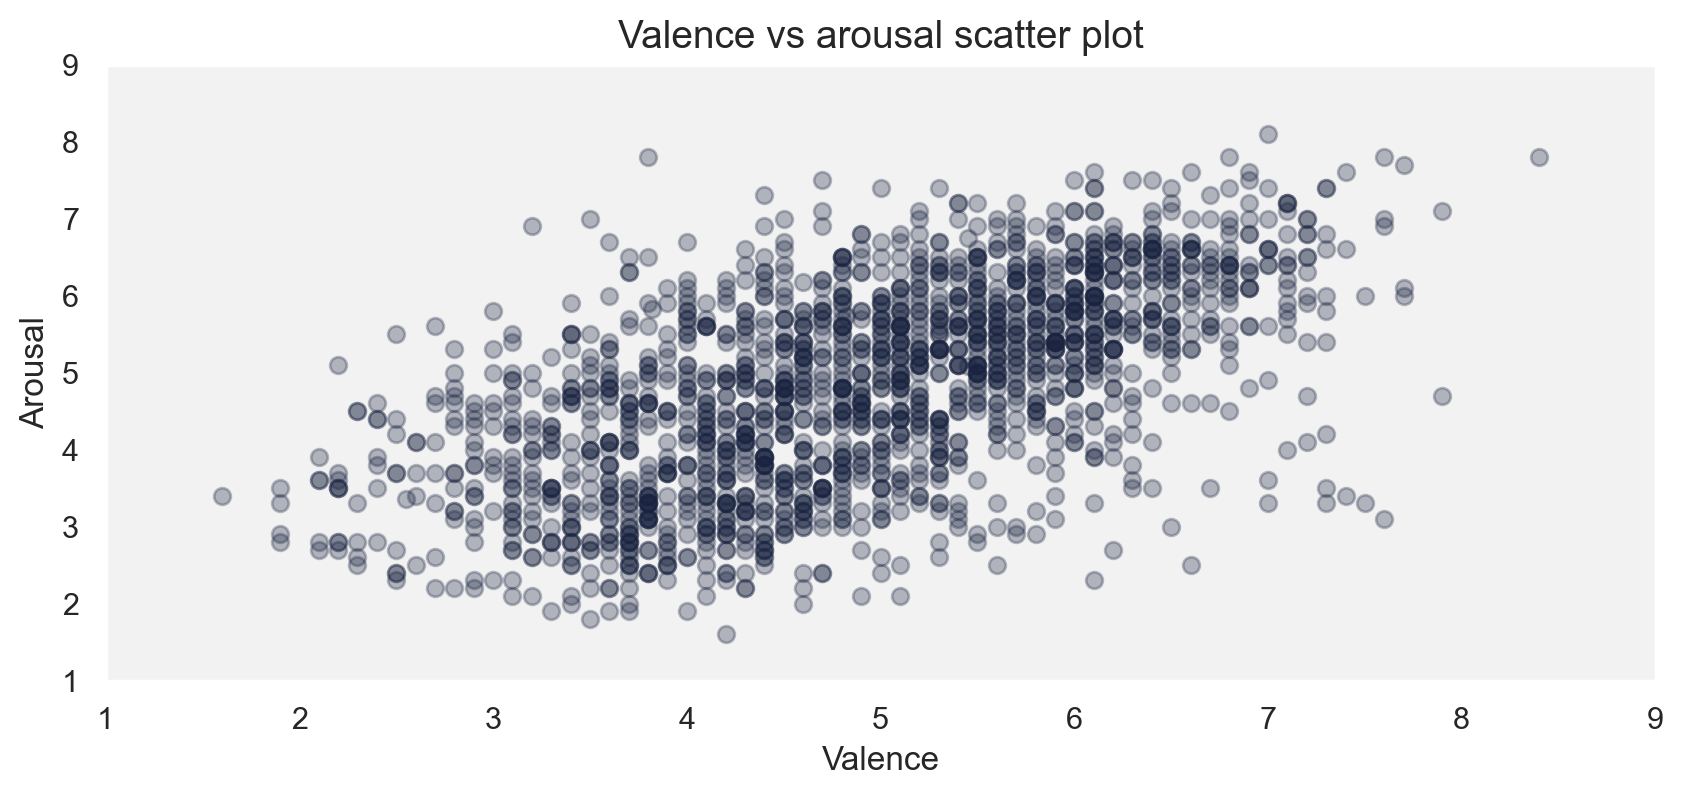

In [15]:
# plot the valence and arousal values distribution
plt.scatter(df["valence_mean"], df["arousal_mean"], alpha=.3)
plt.title("Valence vs Arousal (Mean)", fontsize=14)
plt.xlim([1,9])
plt.ylim([1,9])
plt.xlabel("Valence")
plt.ylabel("Arousal");


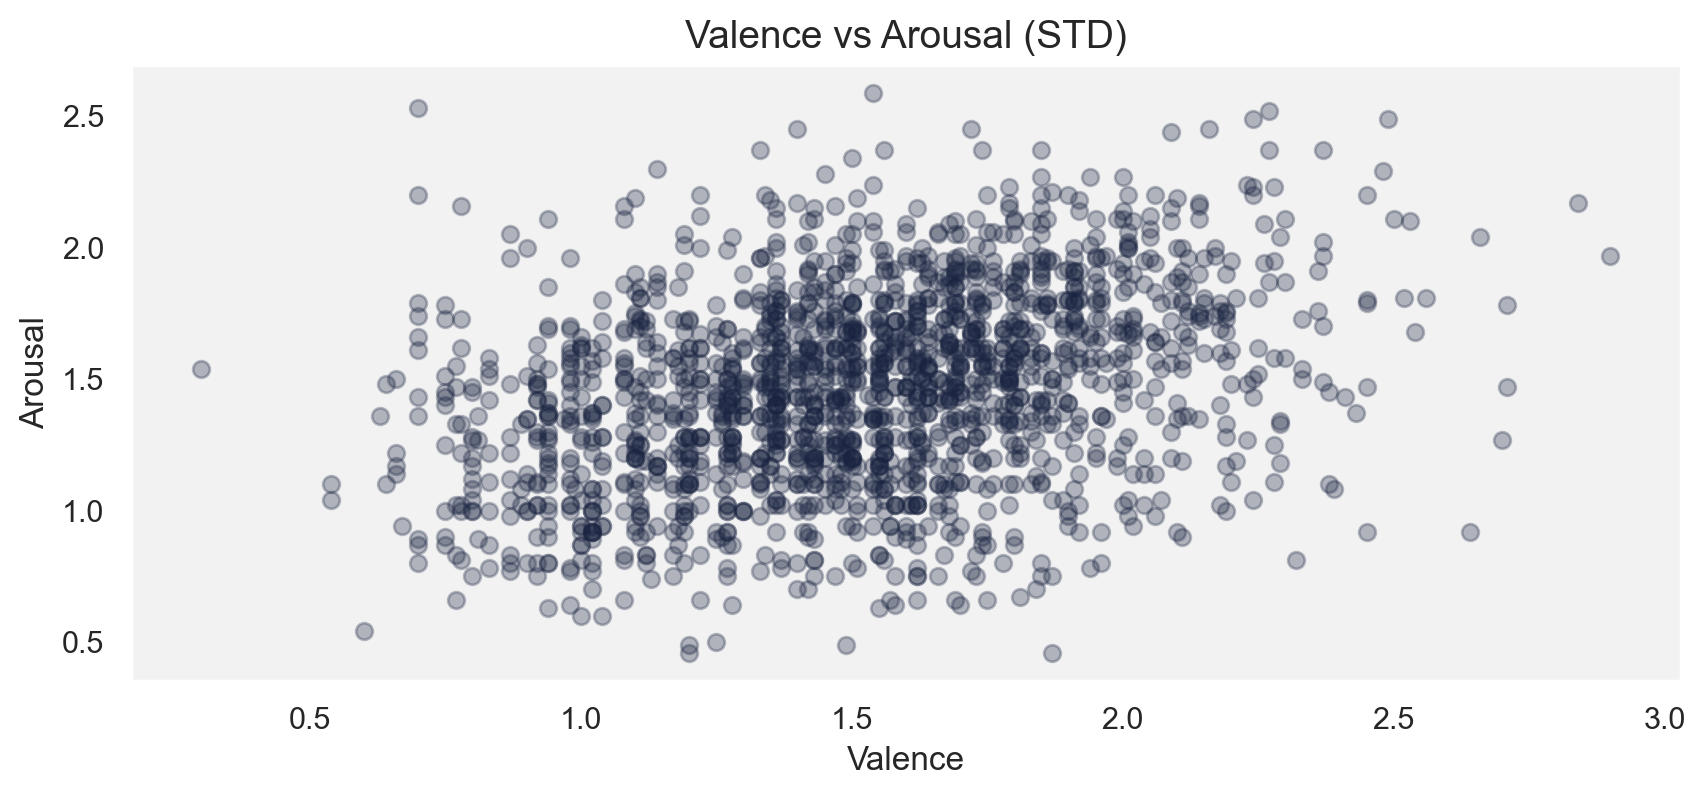

In [20]:
plt.scatter(df["valence_std"], df["arousal_std"], alpha=.3)
plt.title("Valence vs Arousal (STD)", fontsize=14)

plt.xlabel("Valence")
plt.ylabel("Arousal");


Unique genres in the dataset:  126



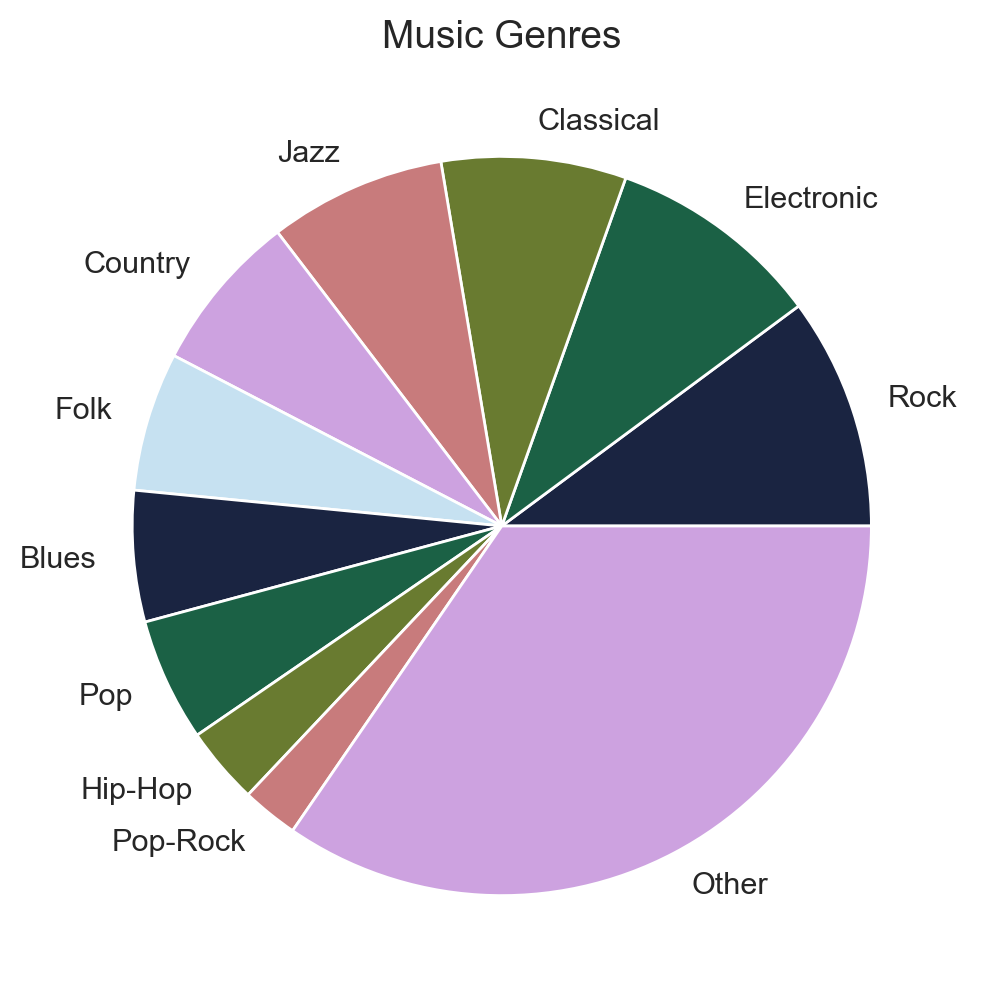

In [21]:
# Genre classes balance
# count the number of genres present in the dataset
nunique_genres = df["genre"].nunique()
print("Unique genres in the dataset:  {}\n".format(nunique_genres))

# select the top 10
top10_genres = df["genre"].value_counts()[:10]
top10_genres.loc["Other"] = df["genre"].value_counts()[10:].sum()

# plot a pie chart with genres ratio
plt.figure(figsize=(6,6))
labels = top10_genres.index
plt.pie(top10_genres, labels=labels)
plt.title("Music Genres", fontsize=14);

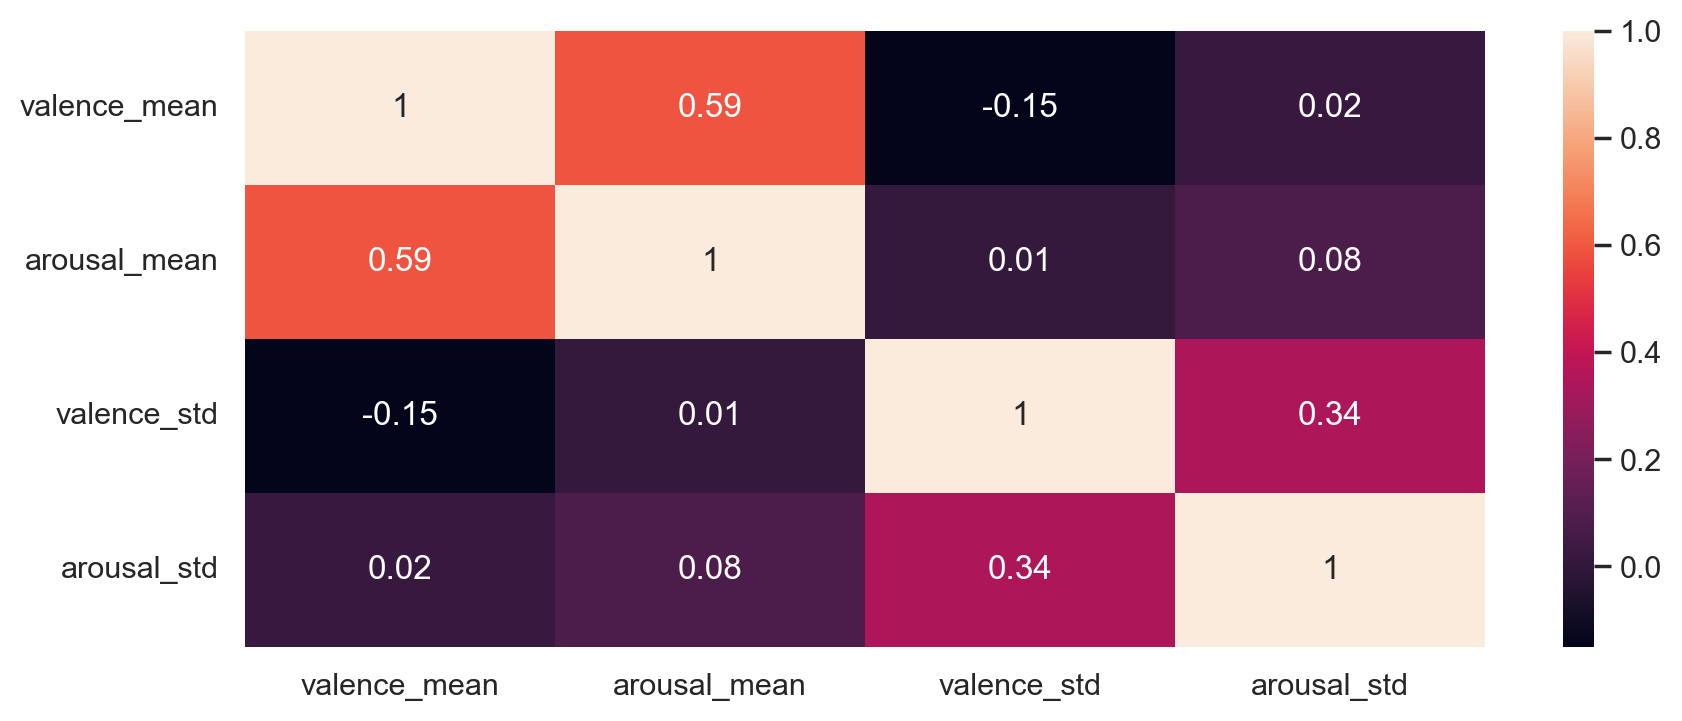

In [22]:
cols = ["valence_mean", "arousal_mean", "valence_std", "arousal_std"]
corr_matrix = df[cols].corr().round(2)
sns.heatmap(corr_matrix, annot=True)
plt.show()

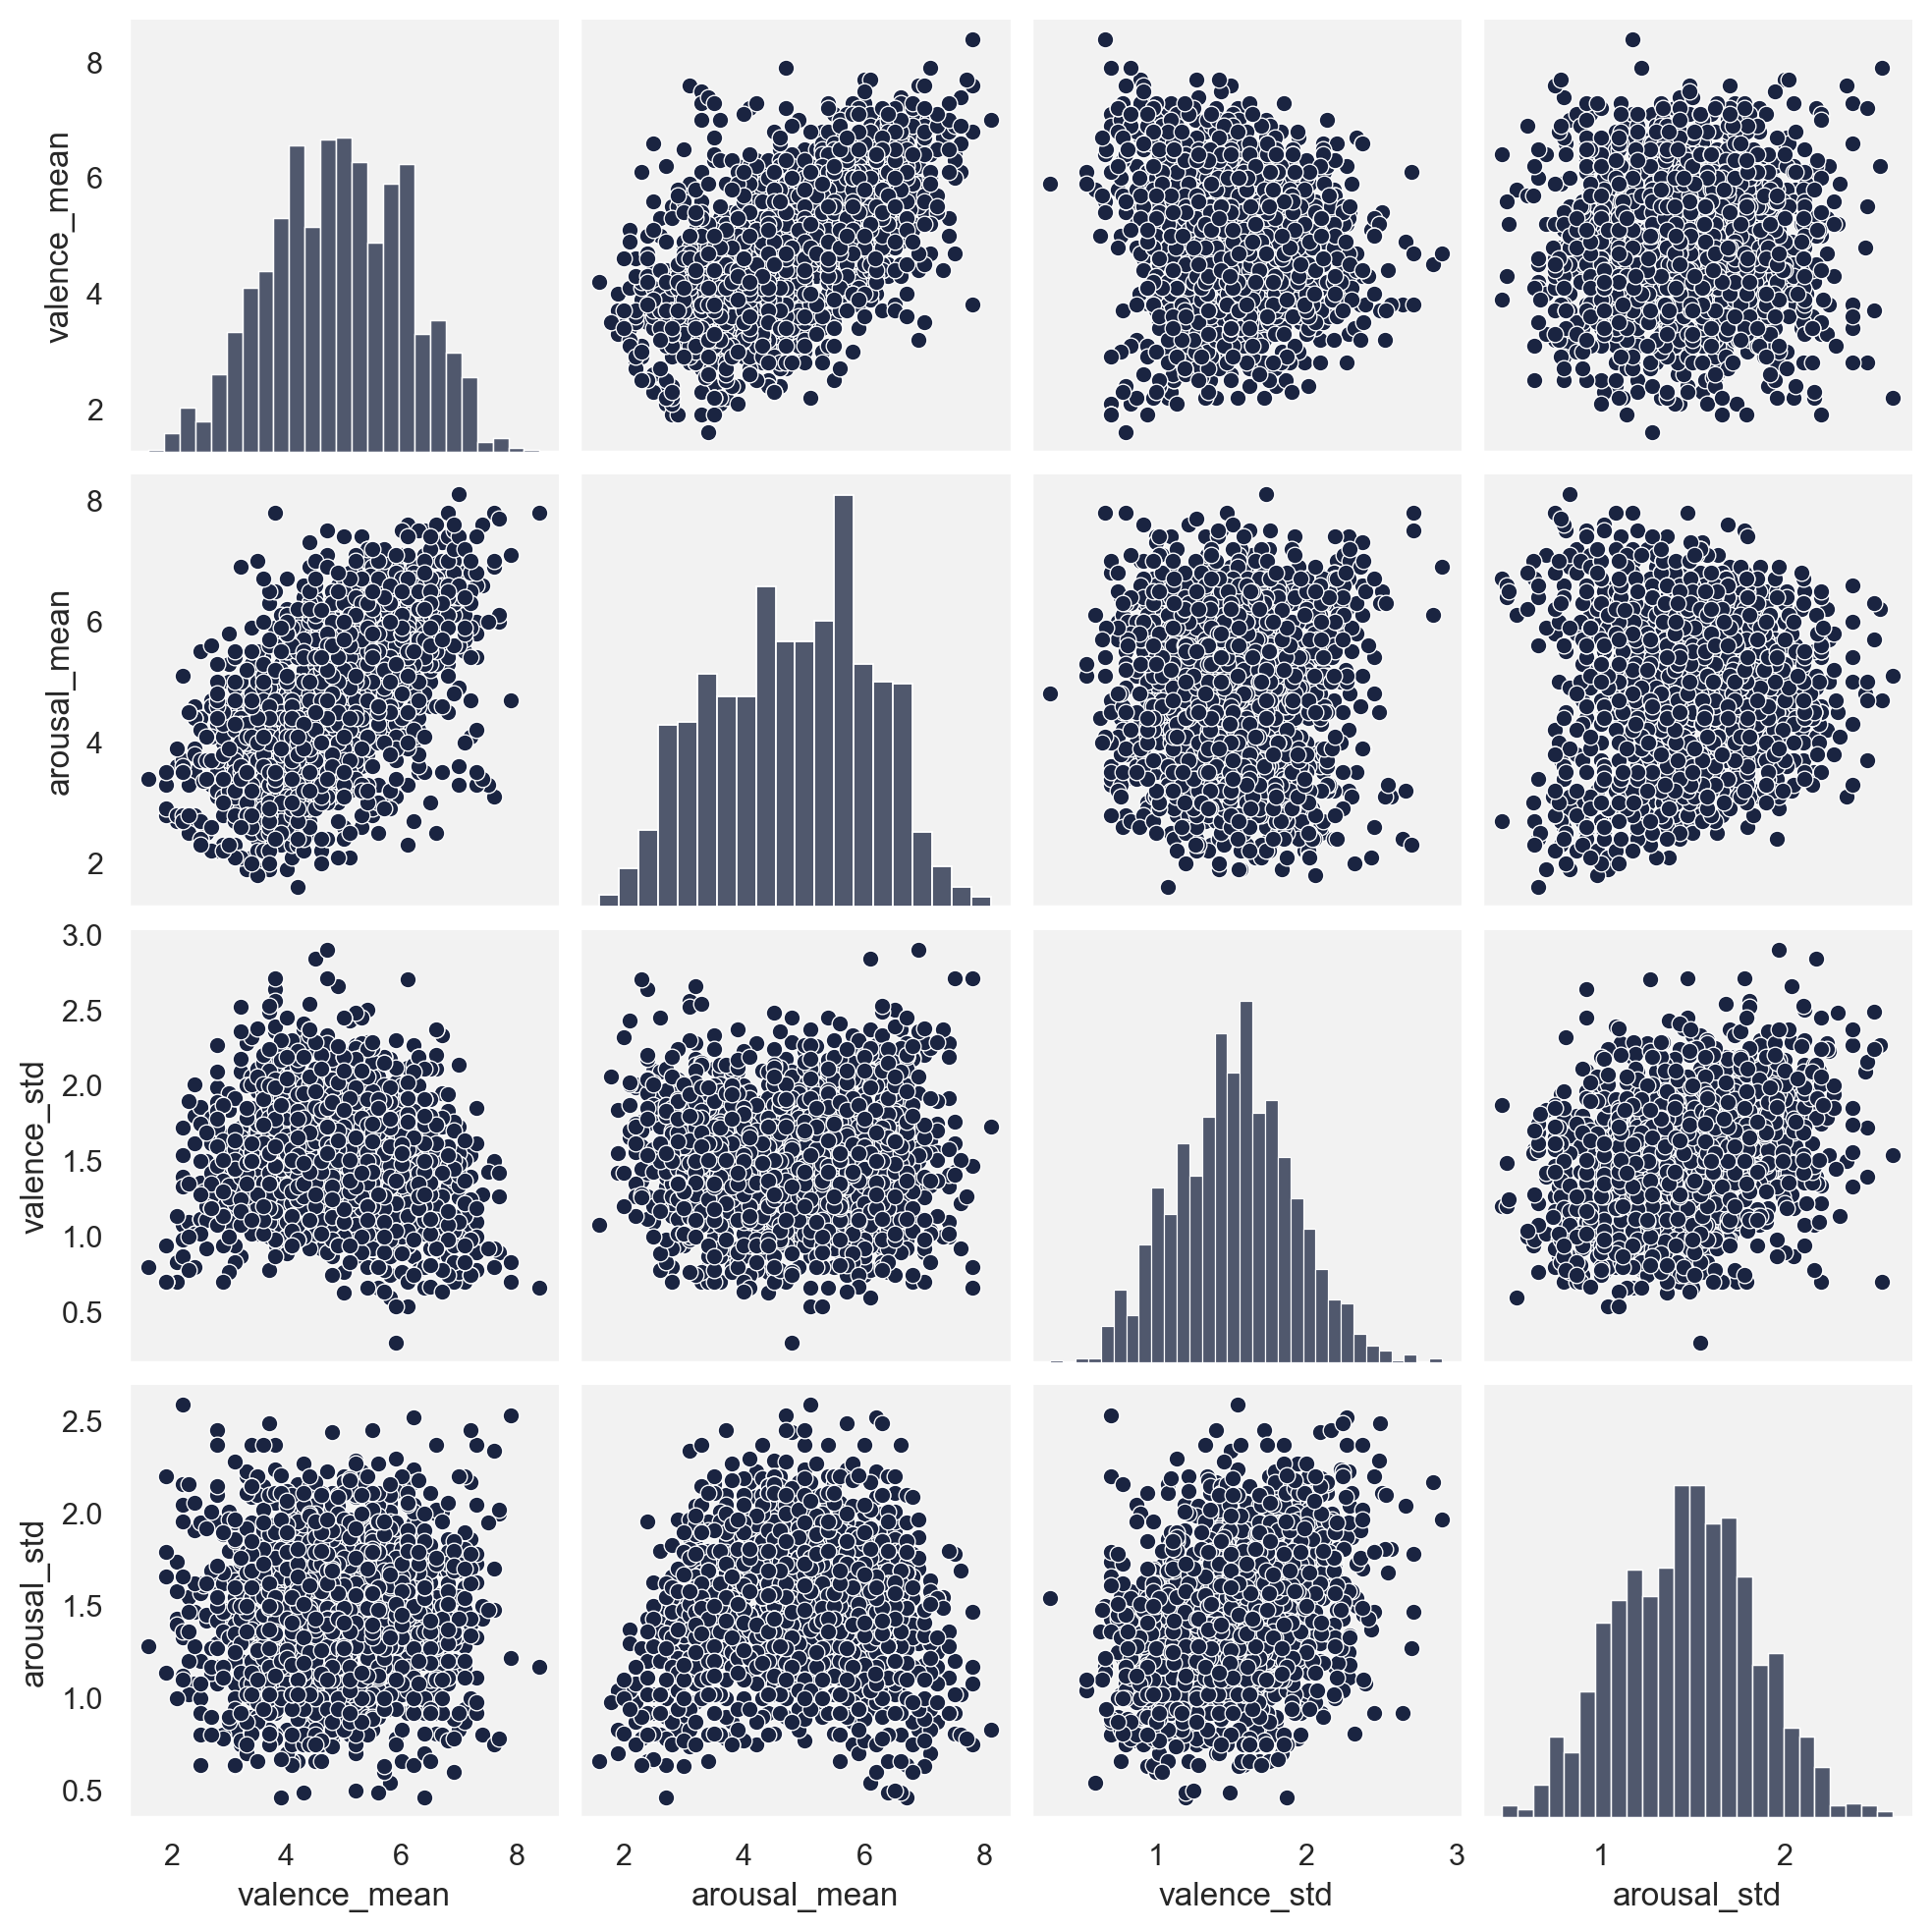

In [23]:
df.corr()
sns.pairplot(df[cols])


## Sample Audio 

/opt/homebrew/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


Sampling rate: 22050
song_id                                                        979
valence                                                        3.1
arousal                                                        5.5
file_name                                                  979.mp3
artist                                                  Rue Royale
song_title                                          Deck the Halls
segment_start                                                 0.24
segment_end                                                   1.09
genre                                                         Rock
file_path        /Users/gguillau/Desktop/Practicum/Cuetessa Pro...
Name: 726, dtype: object


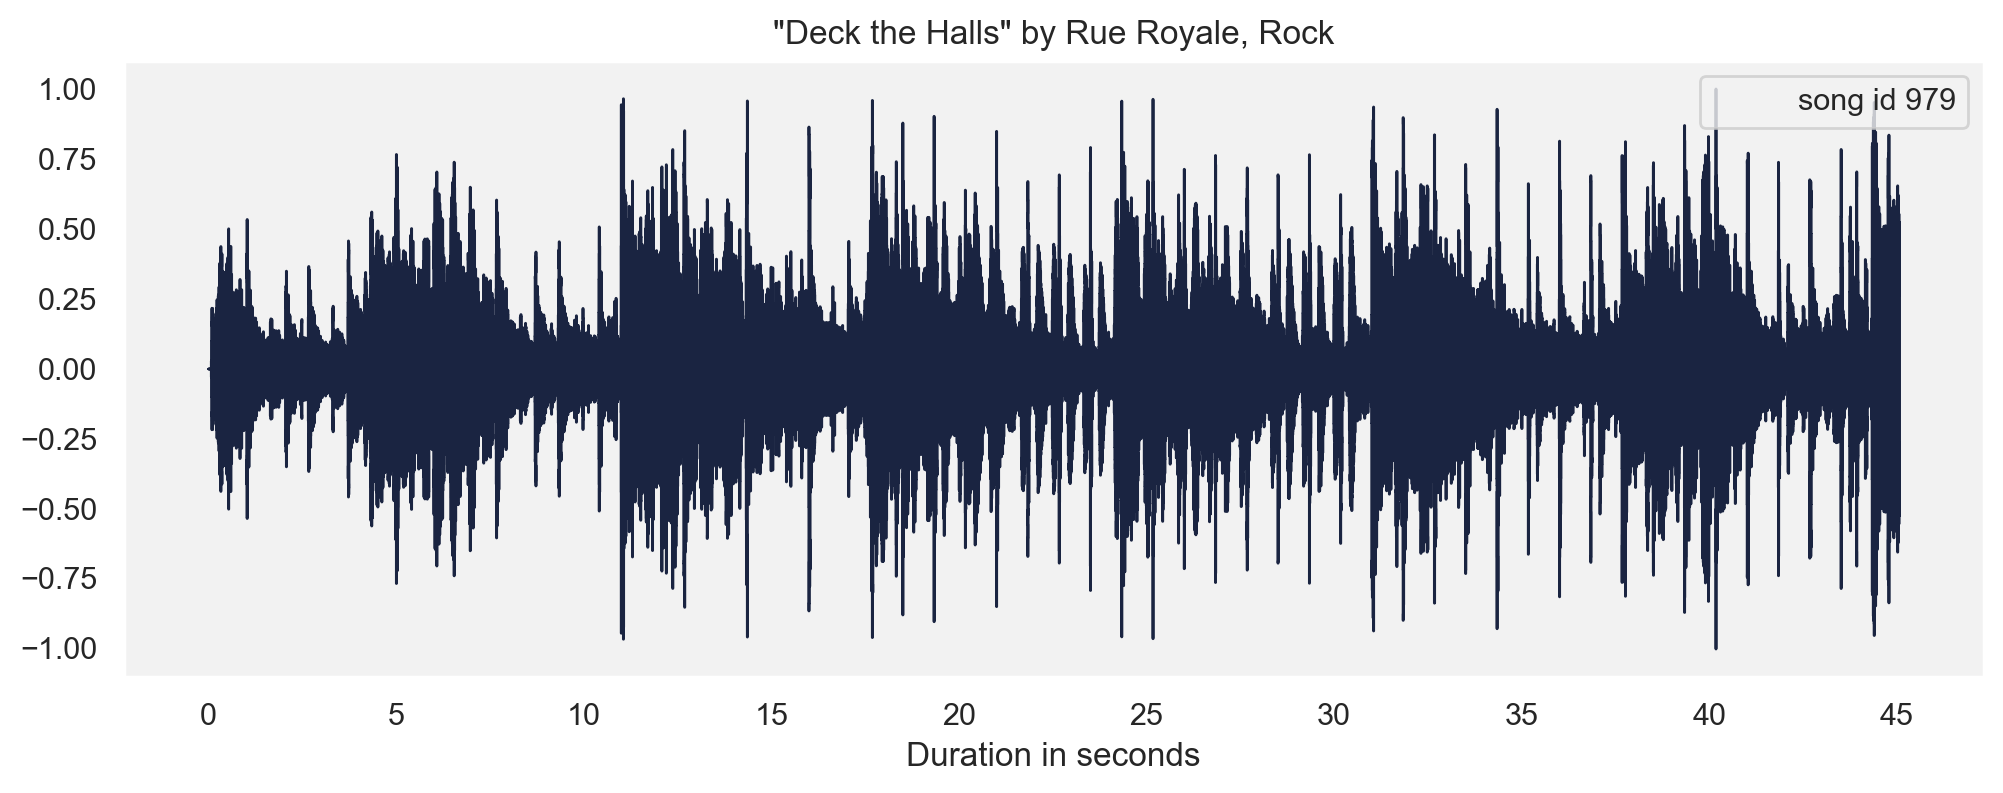

In [17]:
random_idx = np.random.randint(0, 1744)

# select a random song from the dataset
song = df.loc[random_idx, :]

# load the file and print its sampling rate 
file_path = "/Users/gguillau/Desktop/Practicum/Cuetessa Project/deam_data/DEAM_audio/MEMD_audio/" + song["file_name"]
audio, sample_rate = librosa.load(file_path)
# print info about this song
print(f"Sampling rate: {sample_rate}")
print(song)

# plot the wavefrom
plt.figure(figsize=(12,4))
librosa.display.waveshow(audio, sr=sample_rate) # plot a waveform and play the file
plt.title(f'"{song.song_title[:15]}" by {song.artist}, {song.genre}')
plt.legend([f"song id {song.song_id}"])
plt.xlabel("Duration in seconds")

# output the audio
ipd.Audio(file_path)

## Feature Preprocessing

Mel Spectrograms
A Mel Spectrogram makes two important changes relative to a regular Spectrogram that plots Frequency vs Time.

- It uses the Mel Scale instead of Frequency on the y-axis.
- It uses the Decibel Scale instead of Amplitude to indicate colors.


In [18]:
# load the audio file and resample
y, sr = librosa.load(file_path, duration=30, mono=True)
y = librosa.resample(y, orig_sr=sr, target_sr=16000)

# normalize from -1 to 1
y = librosa.util.normalize(y)

# obtain melspectogram with 80 freq. bins
mel_spec = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=80)
mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


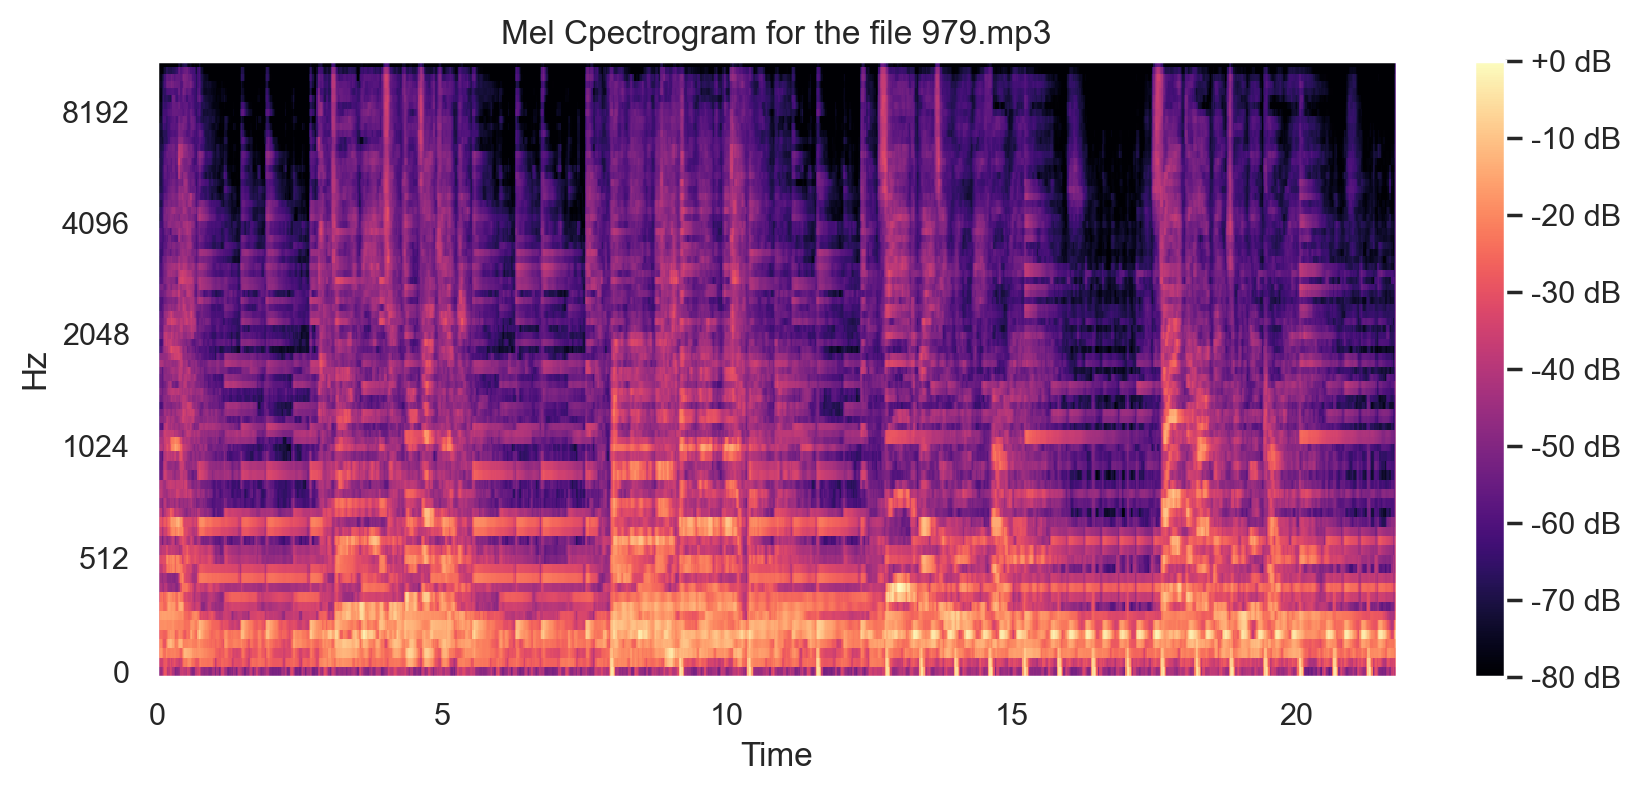

In [19]:
# show the resulting spectogram
librosa.display.specshow(mel_spec, y_axis='mel', x_axis='time')
plt.title("Mel Cpectrogram for the file {}".format(song.file_name));
plt.colorbar(format='%+2.0f dB');

In [ ]:

The audio files need to be converted to mono and then resampled with a Sampling Frequency fs = 16000 Hz to save computing time. To avoid the association of loudness with emotion, all songs need to be normalized to a range from -1.0 to + 1.0. The songs are then converted to Mel-spectograms with the sample rate fs = 16000 Hz and a number of 80 bins. The Power is converted to db.

### Feature Extraction with Librosa 

In [20]:
def get_stats(array):
    """
    Calculates the mean, variance, minimum and maximum values of an array.
    """
    if len(array.shape) > 1:
        feature = np.concatenate(
            (
                np.mean(array, axis=1),
                np.var(array, axis=1),
                np.min(array, axis=1),
                np.max(array, axis=1),
            )
        )
    else:
        feature = np.array(
            (np.mean(array), np.var(array), np.min(array), np.max(array))
        )
    return feature

In [21]:
def get_features(file_path, duration=25):
    """
    Extracts features from an audio file.
    """
    y, sr = librosa.load(file_path, duration=duration)

    mel_spec = librosa.feature.melspectrogram(y=y, sr=16000, n_mels=80)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    features = get_stats(mel_spec)
    return features


In [22]:
#deam_features = np.array([])
#n = df.shape[0]

#for i in tqdm(range(n)):
#     file_path = df.loc[i, "file_path"]
#     deam_features = np.append(deam_features, get_features(file_path), axis=0)


In [23]:
import warnings

warnings.filterwarnings("ignore")


In [1]:

#deam_features = deam_features.reshape(n,320)


NameError: name 'deam_features' is not defined

In [34]:
# # save dataframe with features for further use
#pd.DataFrame(deam_features).to_csv("/Users/gguillau/Desktop/Practicum/Cuetessa Project/deam_data/deam_200_features.csv")


In [26]:
deam_features = pd.read_csv("/Users/gguillau/Desktop/Practicum/Cuetessa Project/deam_data/deam_200_features.csv", index_col=0).values


In [27]:
deam_features.shape

(1744, 320)

## Machine Learning

In [35]:

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_validate, train_test_split
from sklearn.svm import SVR
from sklearn.utils import shuffle
from xgboost import XGBRegressor

In [28]:
X_d = daem_features

y_d = df["valence"].values

# split the data into the train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_d, y_d, test_size=0.2, random_state=seed)

In [29]:
# creata a function for models evaluation
def eval_model(model, X=X_train, y=y_train, show_metrics=1):
    
    # create a pipline to avoid possible target leakage
    pipe = make_pipeline(StandardScaler(), model)
    
    scores = cross_validate(pipe, X, y, cv=5, scoring=("r2", "neg_mean_absolute_error"), n_jobs=-1)
    
    r2 = np.average(scores["test_r2"])
    mae = np.abs(np.average(scores["test_neg_mean_absolute_error"]))
    fit_time = np.average(scores["fit_time"])
    score_time = np.average(scores["score_time"])
    if show_metrics == 1:
        print("Fit time: {:.5f}".format(fit_time))
        print("Score time: {:.5f}".format(score_time))
        print("R2: {:.4f}".format(r2))
        print("MAE {:.4f}".format(mae))
    else:
        return r2, mae

### Support Vector Regression

In [30]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, get_scorer_names 


In [31]:
eval_model(SVR())


Fit time: 0.22093
Score time: 0.07754
R2: 0.4582
MAE 0.6863


### K Nearest Neighbors

In [40]:
eval_model(KNeighborsRegressor())

Fit time: 0.00961
Score time: 0.03167
R2: 0.3251
MAE 0.7630


In [32]:
%%time
# Hyperparameter tuning
params = dict(
     n_neighbors=(5, 6, 7, 8),
     leaf_size=(30, 40, 50,60))

knn = KNeighborsRegressor()

grid = GridSearchCV(
    knn, param_grid=params, n_jobs=-1, scoring="r2"
 )
grid_result = grid.fit(X_train, y_train)

print(
     "Best R2: {:.4f} \nUsing params:\n{}".format(
         grid_result.best_score_, grid_result.best_params_
     )
 )
print()

Best R2: 0.2687 
Using params:
{'leaf_size': 30, 'n_neighbors': 8}

CPU times: user 41.5 ms, sys: 18.7 ms, total: 60.2 ms
Wall time: 549 ms


In [33]:
knn = KNeighborsRegressor(
    n_neighbors = 8, leaf_size = 30
)

eval_model(knn, X_train, y_train)

Fit time: 0.01584
Score time: 0.01484
R2: 0.3534
MAE 0.7519


### Random Forest Regressor

In [34]:
eval_model(RandomForestRegressor())

Fit time: 9.85195
Score time: 0.00722
R2: 0.4387
MAE 0.6984


In [45]:
%%time

# Hyperparameter tuning
params = dict(
     n_neighbors=(5, 6, 7, 8),
     leaf_size=(30, 40, 50,60))

knn = KNeighborsRegressor()

grid = GridSearchCV(
    knn, param_grid=params, n_jobs=-1, scoring="r2"
 )
grid_result = grid.fit(X_train, y_train)

print(
     "Best R2: {:.4f} \nUsing params:\n{}".format(
         grid_result.best_score_, grid_result.best_params_
     )
 )
print()
 params = dict(
     n_estimators=(100, 150, 200),
     max_depth = (2, 6, 10))

rf = RandomForestRegressor()

grid = GridSearchCV(
    rf, param_grid=params, n_jobs=-1, scoring="r2"
 )
grid_result = grid.fit(X_train, y_train)

print(
     "Best R2: {:.4f} \nUsing params:\n{}".format(
         grid_result.best_score_, grid_result.best_params_
     )
 )
print()

Best R2: 0.4413 
Using params:
{'max_depth': 10, 'n_estimators': 150}

CPU times: user 14.4 s, sys: 91.7 ms, total: 14.5 s
Wall time: 1min 21s


In [46]:
rf = RandomForestRegressor(max_depth = 10, n_estimators= 150)
eval_model(rf)


Fit time: 12.89194
Score time: 0.00821
R2: 0.4416
MAE 0.6964


### LGBMRegresor

In [42]:
eval_model(LGBMRegressor())

Fit time: 1.44462
Score time: 0.00528
R2: 0.4313
MAE 0.6960
633:	learn: 0.2411999	total: 31.7s	remaining: 18.3s
634:	learn: 0.2405575	total: 31.7s	remaining: 18.2s
635:	learn: 0.2399507	total: 31.7s	remaining: 18.2s
636:	learn: 0.2396741	total: 31.8s	remaining: 18.1s
637:	learn: 0.2394041	total: 31.8s	remaining: 18.1s
638:	learn: 0.2393035	total: 31.9s	remaining: 18s
639:	learn: 0.2385938	total: 32s	remaining: 18s
640:	learn: 0.2383049	total: 32s	remaining: 17.9s
641:	learn: 0.2378163	total: 32.1s	remaining: 17.9s
642:	learn: 0.2371106	total: 32.1s	remaining: 17.8s
643:	learn: 0.2364770	total: 32.2s	remaining: 17.8s
644:	learn: 0.2357106	total: 32.2s	remaining: 17.7s
645:	learn: 0.2350045	total: 32.3s	remaining: 17.7s
646:	learn: 0.2345847	total: 32.3s	remaining: 17.6s
647:	learn: 0.2339507	total: 32.4s	remaining: 17.6s
648:	learn: 0.2334835	total: 32.4s	remaining: 17.5s
649:	learn: 0.2332856	total: 32.5s	remaining: 17.5s
650:	learn: 0.2324841	total: 32.5s	remaining: 17.4s
651:	learn: 

### CatBoostRegressor

In [38]:
eval_model(CatBoostRegressor())

Learning rate set to 0.041659
0:	learn: 1.1474647	total: 97.6ms	remaining: 1m 37s
1:	learn: 1.1326062	total: 128ms	remaining: 1m 3s
2:	learn: 1.1170629	total: 202ms	remaining: 1m 7s
3:	learn: 1.1035348	total: 260ms	remaining: 1m 4s
4:	learn: 1.0894999	total: 307ms	remaining: 1m 1s
5:	learn: 1.0776752	total: 355ms	remaining: 58.9s
6:	learn: 1.0660189	total: 409ms	remaining: 58s
7:	learn: 1.0555902	total: 460ms	remaining: 57.1s
8:	learn: 1.0453028	total: 527ms	remaining: 58s
9:	learn: 1.0353942	total: 582ms	remaining: 57.6s
10:	learn: 1.0258892	total: 634ms	remaining: 57s
11:	learn: 1.0167515	total: 667ms	remaining: 54.9s
12:	learn: 1.0078031	total: 710ms	remaining: 53.9s
13:	learn: 0.9999610	total: 752ms	remaining: 53s
14:	learn: 0.9915643	total: 808ms	remaining: 53s
15:	learn: 0.9843299	total: 853ms	remaining: 52.5s
16:	learn: 0.9781121	total: 898ms	remaining: 51.9s
17:	learn: 0.9714425	total: 952ms	remaining: 51.9s
18:	learn: 0.9648046	total: 1s	remaining: 51.9s
19:	learn: 0.9588891	t

Learning rate set to 0.041659
0:	learn: 1.1641246	total: 128ms	remaining: 2m 7s
1:	learn: 1.1488341	total: 196ms	remaining: 1m 37s
2:	learn: 1.1333699	total: 248ms	remaining: 1m 22s
3:	learn: 1.1206820	total: 288ms	remaining: 1m 11s
4:	learn: 1.1062314	total: 328ms	remaining: 1m 5s
5:	learn: 1.0943133	total: 359ms	remaining: 59.4s
6:	learn: 1.0826180	total: 416ms	remaining: 59s
7:	learn: 1.0714034	total: 468ms	remaining: 58s
8:	learn: 1.0604792	total: 542ms	remaining: 59.7s
9:	learn: 1.0493923	total: 588ms	remaining: 58.2s
10:	learn: 1.0393637	total: 622ms	remaining: 55.9s
11:	learn: 1.0308884	total: 663ms	remaining: 54.5s
12:	learn: 1.0221194	total: 714ms	remaining: 54.2s
13:	learn: 1.0145259	total: 756ms	remaining: 53.2s
14:	learn: 1.0057720	total: 810ms	remaining: 53.2s
15:	learn: 0.9982128	total: 873ms	remaining: 53.7s
16:	learn: 0.9912683	total: 929ms	remaining: 53.7s
17:	learn: 0.9834840	total: 977ms	remaining: 53.3s
18:	learn: 0.9773750	total: 1.04s	remaining: 53.8s
19:	learn: 0

202:	learn: 0.6188634	total: 9.43s	remaining: 37s
203:	learn: 0.6173331	total: 9.48s	remaining: 37s
204:	learn: 0.6162790	total: 9.53s	remaining: 37s
205:	learn: 0.6146362	total: 9.56s	remaining: 36.9s
206:	learn: 0.6133271	total: 9.6s	remaining: 36.8s
207:	learn: 0.6129402	total: 9.65s	remaining: 36.7s
208:	learn: 0.6119269	total: 9.7s	remaining: 36.7s
209:	learn: 0.6113532	total: 9.74s	remaining: 36.6s
210:	learn: 0.6103775	total: 9.79s	remaining: 36.6s
211:	learn: 0.6099746	total: 9.84s	remaining: 36.6s
212:	learn: 0.6081108	total: 9.89s	remaining: 36.5s
213:	learn: 0.6070407	total: 9.96s	remaining: 36.6s
214:	learn: 0.6057733	total: 10s	remaining: 36.6s
215:	learn: 0.6052064	total: 10.1s	remaining: 36.5s
216:	learn: 0.6041805	total: 10.1s	remaining: 36.4s
217:	learn: 0.6025537	total: 10.1s	remaining: 36.4s
218:	learn: 0.6011378	total: 10.2s	remaining: 36.3s
219:	learn: 0.5999541	total: 10.2s	remaining: 36.3s
220:	learn: 0.5980927	total: 10.3s	remaining: 36.3s
221:	learn: 0.5971219	

138:	learn: 0.6912404	total: 6.49s	remaining: 40.2s
139:	learn: 0.6902681	total: 6.54s	remaining: 40.2s
140:	learn: 0.6895967	total: 6.59s	remaining: 40.1s
141:	learn: 0.6884416	total: 6.63s	remaining: 40.1s
142:	learn: 0.6868931	total: 6.68s	remaining: 40s
143:	learn: 0.6856166	total: 6.73s	remaining: 40s
144:	learn: 0.6841594	total: 6.79s	remaining: 40s
145:	learn: 0.6826370	total: 6.82s	remaining: 39.9s
146:	learn: 0.6808454	total: 6.89s	remaining: 40s
147:	learn: 0.6795357	total: 6.96s	remaining: 40s
148:	learn: 0.6787752	total: 6.99s	remaining: 39.9s
149:	learn: 0.6775556	total: 7.03s	remaining: 39.9s
150:	learn: 0.6764899	total: 7.08s	remaining: 39.8s
151:	learn: 0.6755938	total: 7.13s	remaining: 39.8s
152:	learn: 0.6740751	total: 7.18s	remaining: 39.8s
153:	learn: 0.6728185	total: 7.24s	remaining: 39.8s
154:	learn: 0.6713549	total: 7.29s	remaining: 39.7s
155:	learn: 0.6698890	total: 7.33s	remaining: 39.7s
156:	learn: 0.6689276	total: 7.38s	remaining: 39.6s
157:	learn: 0.6672614	

318:	learn: 0.4775627	total: 14.5s	remaining: 31s
319:	learn: 0.4764150	total: 14.5s	remaining: 30.9s
320:	learn: 0.4751500	total: 14.6s	remaining: 30.8s
321:	learn: 0.4735459	total: 14.6s	remaining: 30.8s
322:	learn: 0.4731836	total: 14.7s	remaining: 30.7s
323:	learn: 0.4720958	total: 14.7s	remaining: 30.7s
324:	learn: 0.4717872	total: 14.7s	remaining: 30.6s
325:	learn: 0.4706185	total: 14.8s	remaining: 30.7s
326:	learn: 0.4689492	total: 14.9s	remaining: 30.6s
327:	learn: 0.4687390	total: 14.9s	remaining: 30.6s
328:	learn: 0.4674941	total: 15s	remaining: 30.5s
329:	learn: 0.4671781	total: 15s	remaining: 30.5s
330:	learn: 0.4661747	total: 15.1s	remaining: 30.4s
331:	learn: 0.4645055	total: 15.1s	remaining: 30.4s
332:	learn: 0.4634127	total: 15.1s	remaining: 30.3s
333:	learn: 0.4619694	total: 15.2s	remaining: 30.3s
334:	learn: 0.4610281	total: 15.2s	remaining: 30.2s
335:	learn: 0.4608348	total: 15.3s	remaining: 30.2s
336:	learn: 0.4593708	total: 15.3s	remaining: 30.1s
337:	learn: 0.4585

317:	learn: 0.4707765	total: 14.8s	remaining: 31.8s
318:	learn: 0.4696222	total: 14.9s	remaining: 31.7s
319:	learn: 0.4682269	total: 15s	remaining: 31.9s
320:	learn: 0.4668718	total: 15s	remaining: 31.8s
321:	learn: 0.4656032	total: 15.1s	remaining: 31.7s
322:	learn: 0.4646186	total: 15.1s	remaining: 31.7s
323:	learn: 0.4637123	total: 15.2s	remaining: 31.7s
324:	learn: 0.4619635	total: 15.2s	remaining: 31.6s
325:	learn: 0.4606072	total: 15.3s	remaining: 31.6s
326:	learn: 0.4593149	total: 15.3s	remaining: 31.5s
327:	learn: 0.4583690	total: 15.3s	remaining: 31.4s
328:	learn: 0.4575283	total: 15.4s	remaining: 31.4s
329:	learn: 0.4566300	total: 15.4s	remaining: 31.3s
330:	learn: 0.4559181	total: 15.5s	remaining: 31.3s
331:	learn: 0.4555879	total: 15.5s	remaining: 31.2s
332:	learn: 0.4540418	total: 15.6s	remaining: 31.2s
333:	learn: 0.4538529	total: 15.6s	remaining: 31.1s
334:	learn: 0.4533817	total: 15.6s	remaining: 31.1s
335:	learn: 0.4523619	total: 15.7s	remaining: 31s
336:	learn: 0.4519

317:	learn: 0.4795218	total: 14.8s	remaining: 31.8s
318:	learn: 0.4784653	total: 14.9s	remaining: 31.7s
319:	learn: 0.4766976	total: 14.9s	remaining: 31.7s
320:	learn: 0.4755556	total: 15s	remaining: 31.7s
321:	learn: 0.4748993	total: 15s	remaining: 31.6s
322:	learn: 0.4739932	total: 15.1s	remaining: 31.5s
323:	learn: 0.4727222	total: 15.1s	remaining: 31.5s
324:	learn: 0.4714349	total: 15.1s	remaining: 31.4s
325:	learn: 0.4701852	total: 15.2s	remaining: 31.4s
326:	learn: 0.4690959	total: 15.2s	remaining: 31.3s
327:	learn: 0.4679081	total: 15.3s	remaining: 31.3s
328:	learn: 0.4675462	total: 15.3s	remaining: 31.2s
329:	learn: 0.4661912	total: 15.4s	remaining: 31.2s
330:	learn: 0.4653789	total: 15.4s	remaining: 31.1s
331:	learn: 0.4638638	total: 15.5s	remaining: 31.1s
332:	learn: 0.4626348	total: 15.5s	remaining: 31.1s
333:	learn: 0.4617994	total: 15.6s	remaining: 31s
334:	learn: 0.4612104	total: 15.6s	remaining: 31s
335:	learn: 0.4600906	total: 15.6s	remaining: 30.9s
336:	learn: 0.459840

Fit time: 51.57549
Score time: 0.02582
R2: 0.4534
MAE 0.6898


### XGBRegressor

In [40]:
eval_model(XGBRegressor(random_state = seed))

Fit time: 3.77753
Score time: 0.00239
R2: 0.3601
MAE 0.7479
